In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
# Check tensorflow version. 
print(tf.__version__)

2.3.1


#### Time series forecasting 

A time series is a series of data points indexed (or listed or graphed) in time order. Most commonly, a time series is a sequence taken at successive equally spaced points in time. Thus it is a sequence of discrete-time data.

Time series forecasting is the use of a model to predict future values based on previously observed values.

#### Load Dataset

In [3]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)

csv_path, _ = os.path.splitext(zip_path)

In [4]:
weather_df = pd.read_csv(csv_path)
weather_df.head(3)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6


Here we only deal with **hourly predictions**, so start by sub-sampling the data from 10 minute intervals to 1h. So take every 6th record as this data generated for every 10 min interval.

In [5]:
# slice [start:stop:step], starting from index 5 take every 6th record.
weather_df_hourly = weather_df[5::6]
weather_df_hourly.head(10)

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,01.01.2009 01:00:00,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,01.01.2009 02:00:00,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,01.01.2009 03:00:00,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,01.01.2009 04:00:00,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,01.01.2009 05:00:00,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
35,01.01.2009 06:00:00,997.71,-9.67,263.66,-10.62,92.7,2.93,2.71,0.21,1.69,2.72,1317.71,0.05,0.50,146.0
41,01.01.2009 07:00:00,998.33,-9.17,264.12,-10.10,92.9,3.04,2.83,0.22,1.76,2.83,1315.98,2.08,2.88,348.8
47,01.01.2009 08:00:00,999.17,-8.10,265.12,-9.05,92.8,3.31,3.07,0.24,1.92,3.08,1311.65,0.72,1.25,213.9
53,01.01.2009 09:00:00,999.69,-7.66,265.52,-8.84,91.2,3.43,3.13,0.30,1.95,3.13,1310.14,0.34,0.63,202.2
59,01.01.2009 10:00:00,1000.27,-7.04,266.10,-8.17,91.6,3.60,3.30,0.30,2.05,3.29,1307.76,1.45,3.00,292.6


In [6]:
# Remove Date Time column for now. We can add it later.
date_time = pd.to_datetime(weather_df_hourly.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
date_time

5        2009-01-01 01:00:00
11       2009-01-01 02:00:00
17       2009-01-01 03:00:00
23       2009-01-01 04:00:00
29       2009-01-01 05:00:00
                 ...        
420521   2016-12-31 19:10:00
420527   2016-12-31 20:10:00
420533   2016-12-31 21:10:00
420539   2016-12-31 22:10:00
420545   2016-12-31 23:10:00
Name: Date Time, Length: 70091, dtype: datetime64[ns]

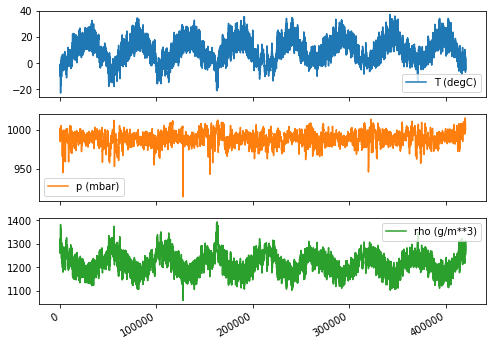

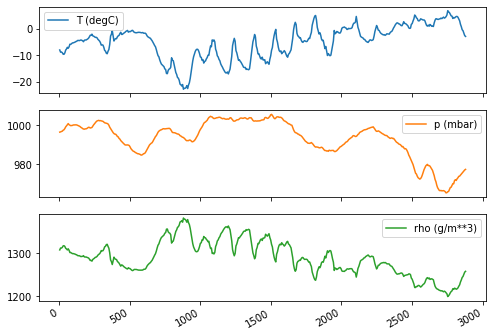

In [7]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = weather_df_hourly[plot_cols]
_ = plot_features.plot(subplots=True)

plot_features = weather_df_hourly[plot_cols][:480]
_ = plot_features.plot(subplots=True)

#### Preprocess

In [8]:
# Inspect the data. 
weather_df_hourly.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


**Wind velocity**

One thing that should stand out is the min value of the wind velocity, wv (m/s) and max. wv (m/s) columns. This -9999 is likely erroneous. There's a separate wind direction column, so the velocity should be >=0. Replace it with zeros:


Clean up on wind, velocity. Not to worry much. It requires some knowledge about the data.

In [9]:
wv = weather_df_hourly['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = weather_df_hourly['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
print(weather_df_hourly['wv (m/s)'].min())

0.0


/usr/local/lib/python3.7/site-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [10]:
wv = weather_df_hourly.pop('wv (m/s)')
max_wv = weather_df_hourly.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = weather_df_hourly.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
weather_df_hourly['Wx'] = wv*np.cos(wd_rad)
weather_df_hourly['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
weather_df_hourly['max Wx'] = max_wv*np.cos(wd_rad)
weather_df_hourly['max Wy'] = max_wv*np.sin(wd_rad)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

**Date Time Column**

Being weather data it has clear **daily and yearly periodicity**. 

Add day and yearly periodicity to the data for better predictions. 

In [11]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [12]:
# Seconds to day, year.
day = 24*60*60
year = (365.2425)*day
day, year

(86400, 31556952.0)

In [13]:
weather_df_hourly['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
weather_df_hourly['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
weather_df_hourly['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
weather_df_hourly['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Text(0.5, 1.0, 'Time of day signal')

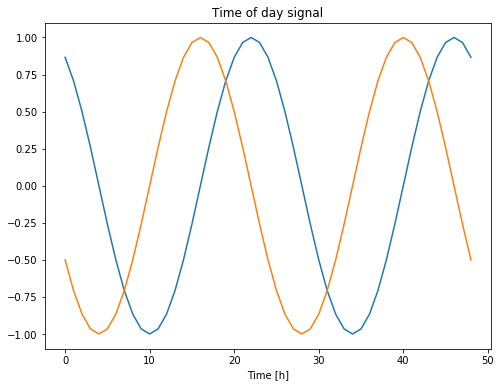

In [14]:
plt.plot(np.array(weather_df_hourly['Day sin'])[:49])
plt.plot(np.array(weather_df_hourly['Day cos'])[:49])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

This gives the model access to the most important frequency features. In this case we knew ahead of time which frequencies were important.

If you didn't know, you can determine which frequencies are important using an fft. To check our assumptions, here is the tf.signal.rfft of the temperature over time. Note the obvious peaks at frequencies near 1/year and 1/day:

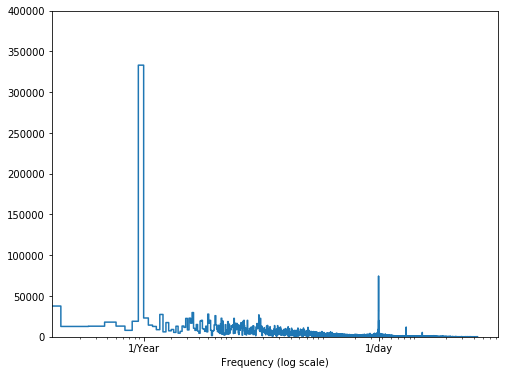

In [15]:
fft = tf.signal.rfft(weather_df_hourly['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(weather_df_hourly['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))


plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

**Split the data**

We'll use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. This is for two reasons.

It ensures that chopping the data into windows of consecutive samples is still possible.
It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [16]:
column_indices = {name: i for i, name in enumerate(weather_df_hourly.columns)}
n = len(weather_df_hourly)

train_df = weather_df_hourly[0:int(n*0.7)]
val_df = weather_df_hourly[int(n*0.7):int(n*0.9)]
test_df = weather_df_hourly[int(n*0.9):]

num_features = weather_df_hourly.shape[1]
num_features

19

#### Normalize the data

In [17]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

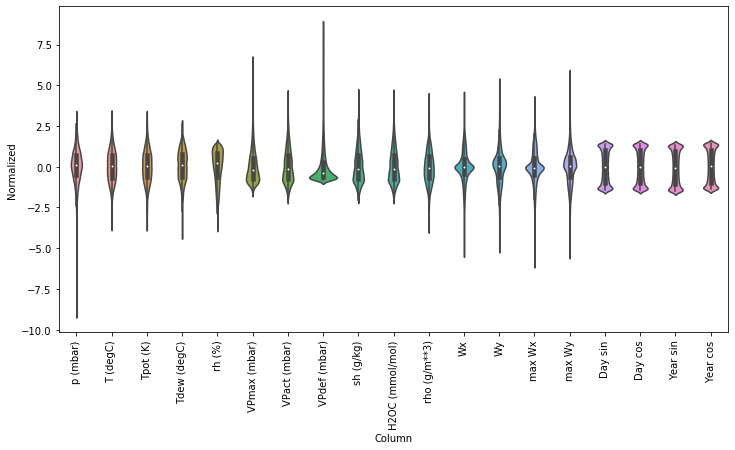

In [18]:
df_std = (weather_df_hourly - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(weather_df_hourly.keys(), rotation=90)

#### Data windowing

The models in this tutorial will make a set of predictions based on a window of consecutive samples from the data.

    The width (number of time steps) of the input and label windows
    The time offset between them(shift).
    Which features are used as inputs, labels, or both.

In [19]:
# Before we get into data prep for actual data, Let's understand with an example.
numpy_data = np.array([[1, 1, 10], [2, 2, 11], [3, 3, 12], [4, 4, 13], [5, 5, 14], [6, 6, 15]])
sample_df = pd.DataFrame(data=numpy_data, columns=["column1", "column2", "column3"])
sample_df.head(10)

,column1,column2,column3
0,1,1,10
1,2,2,11
2,3,3,12
3,4,4,13
4,5,5,14
5,6,6,15


In [20]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
        
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
            
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        
        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    # Split window.
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        return inputs, labels       
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    

    def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                            edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                              marker='X', edgecolors='k', label='Predictions',
                              c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

            plt.xlabel('Time [h]')
            
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
                  data=data,
                  targets=None,
                  sequence_length=self.total_window_size,
                  sequence_stride=1,
                  shuffle=True,
                  batch_size=32,)
        print(self.split_window)
        ds = ds.map(self.split_window)
        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

**Example**

InputWidth = 3
Time offset = 1
Label Width = 1

    Generate Windows Like Below:
    1   1 
    2   2 
    3   3 => 13

    2   2
    3   3 
    4   4 => 14

    3   3
    4   4 
    5   5 => 15



In [21]:
w1 = WindowGenerator(input_width=3, label_width=1, shift=1, label_columns=['column3'], train_df=sample_df)
w1

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['column3']

In [22]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(sample_df[:w1.total_window_size]),
                           np.array(sample_df[1:1+w1.total_window_size]),
                           np.array(sample_df[2:2+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

print(example_inputs, example_labels)

All shapes are: (batch, time, features)
Window shape: (3, 4, 3)
Inputs shape: (3, 3, 3)
labels shape: (3, 1, 1)
tf.Tensor(
[[[ 1  1 10]
  [ 2  2 11]
  [ 3  3 12]]

 [[ 2  2 11]
  [ 3  3 12]
  [ 4  4 13]]

 [[ 3  3 12]
  [ 4  4 13]
  [ 5  5 14]]], shape=(3, 3, 3), dtype=int32) tf.Tensor(
[[[13]]

 [[14]]

 [[15]]], shape=(3, 1, 1), dtype=int32)


In [23]:
for example_inputs, example_labels in w1.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')
    print(example_inputs, example_labels)

<bound method WindowGenerator.split_window of Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['column3']>
Inputs shape (batch, time, features): (3, 3, 3)
Labels shape (batch, time, features): (3, 1, 1)
tf.Tensor(
[[[ 3.  3. 12.]
  [ 4.  4. 13.]
  [ 5.  5. 14.]]

 [[ 2.  2. 11.]
  [ 3.  3. 12.]
  [ 4.  4. 13.]]

 [[ 1.  1. 10.]
  [ 2.  2. 11.]
  [ 3.  3. 12.]]], shape=(3, 3, 3), dtype=float32) tf.Tensor(
[[[15.]]

 [[14.]]

 [[13.]]], shape=(3, 1, 1), dtype=float32)


#### Generate windows on training data. 

In [24]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['T (degC)'], train_df=train_df)
print(w1)

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']


In [25]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, label_columns=['T (degC)'], train_df=train_df)
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [26]:
w3 = WindowGenerator(input_width=2, label_width=1, shift=1, label_columns=['T (degC)'], train_df=train_df)
w3

Total window size: 3
Input indices: [0 1]
Label indices: [2]
Label column name(s): ['T (degC)']

In [27]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)


So far, we prepared the data for training, validation and testing. Also, we have functionality to generate 
windows. 

Now let's look into different models for timeseries problems.


**Single-step Models**

    The simplest model you can build on this sort of data is one that predicts a single feature's value, 
    1 timestep (1h) in the future based only on the current conditions.
    
    
**Multi-step Models**   
    
    In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike 
    a single step model, where only a single future point is predicted, a multi-step model predicts a 
    sequence of the future values.
    
    2 ways to achieve Multi-step Models
        1. Single-shot models:
                One high level approach to this problem is use a "single-shot" model, where the model makes 
                the entire sequence prediction in a single step.
                                
        2. Autoregressive model:
                Each model's output can be fed back into itself at each step and predictions can be 
                made conditioned on the previous one. Example is RNN with 2 or more LSTM layers with 
                return_state = True. 
            
   
We can implement timeseries using below models:

       1. Linear
       2. Dense(Fully connected layers, 2 or more dense layers)
       3. CNN
       4. RNN

Understand the difference between these models, performance. 

In [29]:
# Used by all models.
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(),
                    metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [30]:
val_performance = {}
test_performance = {}

#### Single-step Models

In [31]:
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1, label_columns=['T (degC)'], 
                                     train_df=train_df, test_df=test_df, val_df=val_df)
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

In [32]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

<bound method WindowGenerator.split_window of Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']>
Inputs shape (batch, time, features): (32, 1, 19)
Labels shape (batch, time, features): (32, 1, 1)


**Linear Model**

In [33]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

<bound method WindowGenerator.split_window of Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']>
Input shape: (32, 1, 19)
Output shape: (32, 1, 1)


In [34]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
test_performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

<bound method WindowGenerator.split_window of Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']>
<bound method WindowGenerator.split_window of Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']>
Epoch 1/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.2435 - mean_absolute_error: 0.3212 - val_loss: 0.0201 - val_mean_absolute_error: 0.1058
Epoch 2/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0136 - mean_absolute_error: 0.0868 - val_loss: 0.0102 - val_mean_absolute_error: 0.0746
Epoch 3/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0098 - mean_absolute_error: 0.0728 - val_loss: 0.0091 - val_mean_absolute_error: 0.0708
Epoch 4/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0093 - mean_absolute_error: 0.0709 - val_loss: 0.0089 - val_mean_absolute_error: 0.0703
Epoch 5/20
1534/1534 [==============================] 

Linear model can be called on batches of wide windows. Used this way the model makes a set of independent predictions on consecuitive time steps. The time axis acts like another batch axis. There are no interactions between the precictions at each time step.

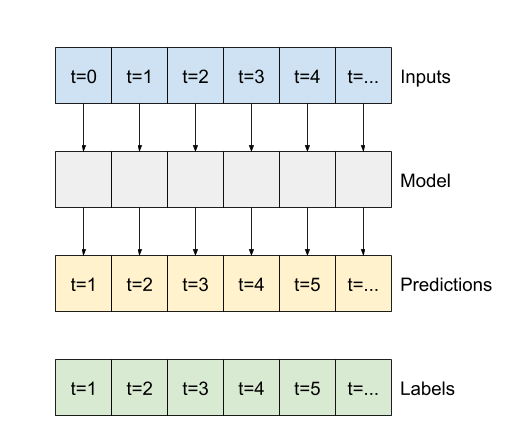

Pros: Easy to interpret

Cons: No information about previous timesteps captured. It may work well for single step models. 

**Dense Model**

In [35]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
test_performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

<bound method WindowGenerator.split_window of Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']>
<bound method WindowGenerator.split_window of Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']>
Epoch 1/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0142 - mean_absolute_error: 0.0784 - val_loss: 0.0084 - val_mean_absolute_error: 0.0676
Epoch 2/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0079 - mean_absolute_error: 0.0644 - val_loss: 0.0075 - val_mean_absolute_error: 0.0625
Epoch 3/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0074 - mean_absolute_error: 0.0618 - val_loss: 0.0068 - val_mean_absolute_error: 0.0590
Epoch 4/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0071 - mean_absolute_error: 0.0604 - val_loss: 0.0070 - val_mean_absolute_error: 0.0604
Epoch 5/20
1534/1534 [==============================] 

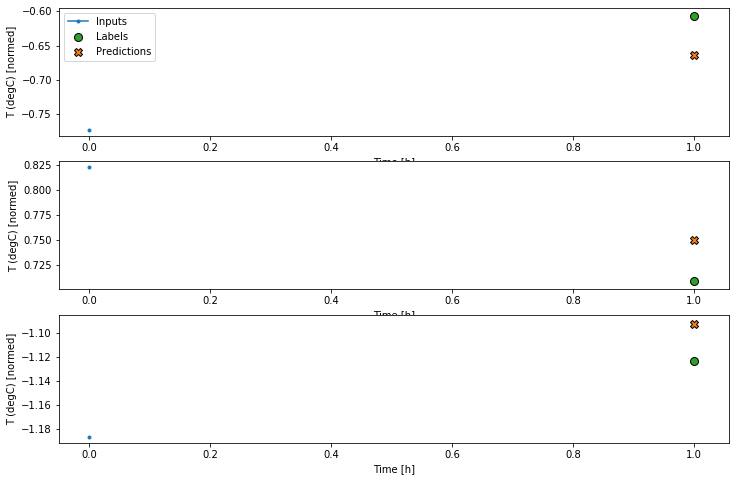

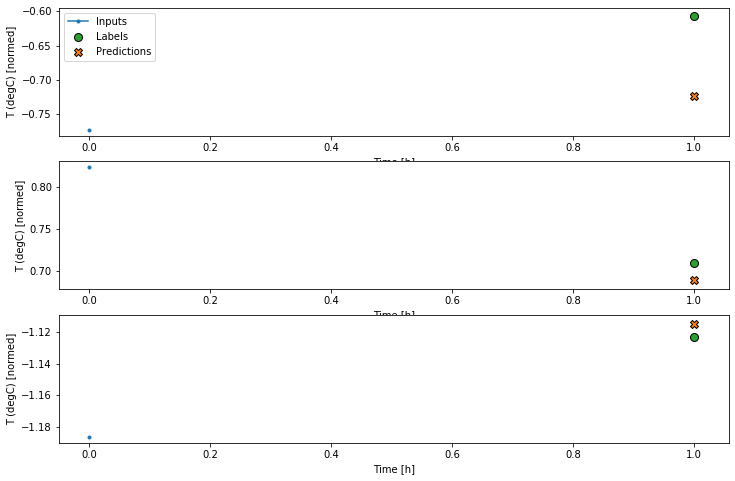

In [36]:
# Plot
single_step_window.plot(linear)

single_step_window.plot(dense)

In [37]:
wide_window = WindowGenerator(input_width=24, label_width=24, shift=1, label_columns=['T (degC)'], train_df=train_df)
print(wide_window)

print('Input shape:', wide_window.example[0].shape)
print('Linear Model Output shape:', dense(wide_window.example[0]).shape)
print('Dense Model Output shape:', linear(wide_window.example[0]).shape)

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']
<bound method WindowGenerator.split_window of Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['T (degC)']>
Input shape: (32, 24, 19)
Linear Model Output shape: (32, 24, 1)
Dense Model Output shape: (32, 24, 1)


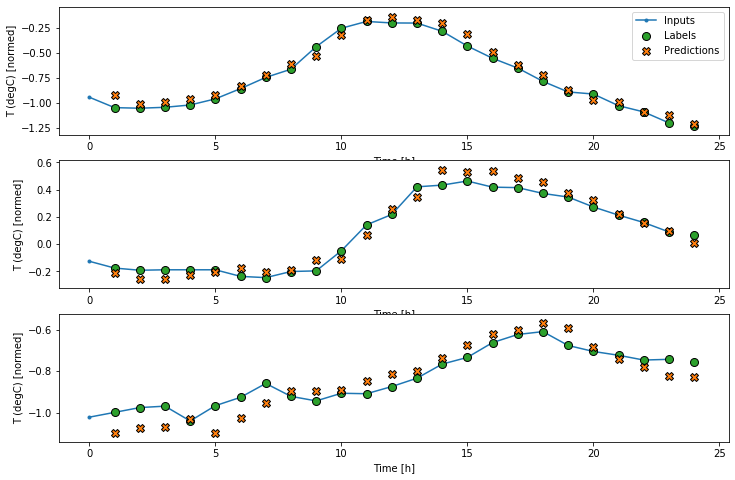

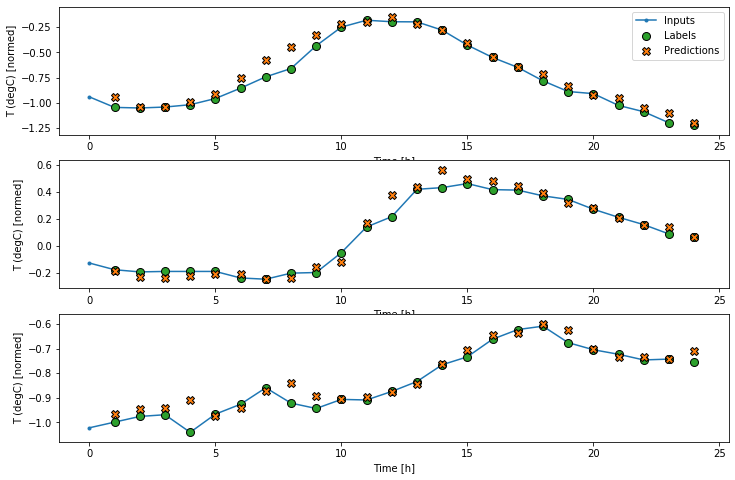

In [38]:
wide_window.plot(linear)
wide_window.plot(dense)

#### Multi-step Models. 

CNN and RNN can be used on single step. But for now skipping to directly on multi step. 

In [42]:
multi_step_window = WindowGenerator(
    input_width=3,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

multi_step_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

In [43]:
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['T (degC)']

**Dense Model**

    You could train a dense model on a multiple-input-step window by adding a layers.
    Flatten as the first layer of the model.
    
    
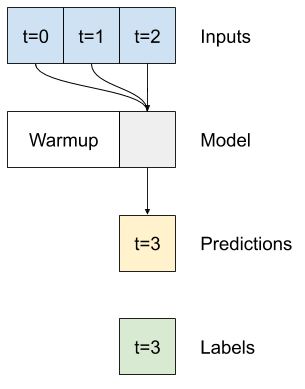

In [44]:
# tf.keras.layers.Flatten() => Flattens the input. Does not affect the batch size.
# Example on how flatten works.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, 3, 3, input_shape=(3, 32, 32)))
print("Original Shape: ", model.output_shape)

model.add(tf.keras.layers.Flatten())
print("Flatten Shape: ", model.output_shape)

Original Shape:  (None, 1, 10, 64)
Flatten Shape:  (None, 640)


In [45]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [46]:
history = compile_and_fit(multi_step_dense, multi_step_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(multi_step_window.val)
test_performance['Multi step dense'] = multi_step_dense.evaluate(multi_step_window.test, verbose=0)

<bound method WindowGenerator.split_window of Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']>
438/438 [==============================] - 0s 1ms/step - loss: 0.0075 - mean_absolute_error: 0.0640
<bound method WindowGenerator.split_window of Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']>


In [47]:
print(multi_step_window)
print('Input shape:', multi_step_window.example[0].shape)
print('Output shape:', multi_step_dense(multi_step_window.example[0]).shape)

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']
<bound method WindowGenerator.split_window of Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']>
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


One problem with this approach is, As we are flattening timesteps*features results the model can only be executed on same input windows. See below inferencing with different window size causes exception. 

In [48]:
print('Input shape:', wide_window.example[0].shape)
try:
    print('Output shape:', multi_step_dense(wide_window.example[0]))
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)

InvalidArgumentError:Matrix size-incompatible: In[0]: [32,456], In[1]: [57,32] [Op:MatMul]


#### Convolution neural network

Below is the same model as multi_step_dense, re-written with a convolution.

Note the changes:

    The layers.Flatten and the first layers.Dense are replaced by a layers.Conv1D.
    The layers.Reshape is no longer necessary since the convolution keeps the time axis in its output.



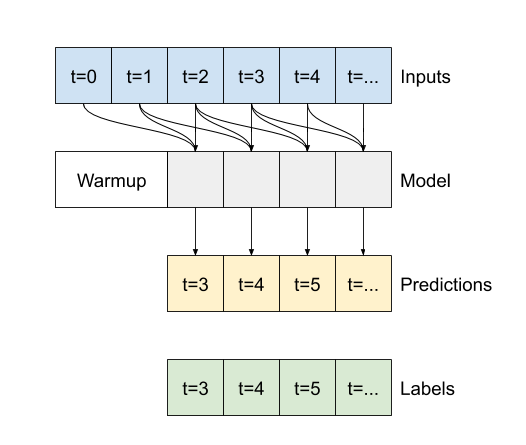

In [49]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']

In [50]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [51]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
<bound method WindowGenerator.split_window of Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']>
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [52]:
history = compile_and_fit(conv_model, conv_window)
IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
test_performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

<bound method WindowGenerator.split_window of Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']>
438/438 [==============================] - 0s 1ms/step - loss: 0.0062 - mean_absolute_error: 0.0555
<bound method WindowGenerator.split_window of Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['T (degC)']>


In [53]:
print('Input shape:', wide_window.example[0].shape)
try:
    print('Output shape:', conv_model(wide_window.example[0]))
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 19)
Output shape: tf.Tensor(
[[[-1.082444  ]
  [-0.9978757 ]
  [-0.92249024]
  [-0.8022839 ]
  [-0.6507757 ]
  [-0.5133026 ]
  [-0.46398407]
  [-0.18938439]
  [-0.23490752]
  [-0.16914257]
  [-0.24539097]
  [-0.29087776]
  [-0.3944162 ]
  [-0.5471771 ]
  [-0.625948  ]
  [-0.7106438 ]
  [-0.8443523 ]
  [-0.9580618 ]
  [-0.9589339 ]
  [-1.0684158 ]
  [-1.1314455 ]
  [-1.2331669 ]]

 [[-0.20687386]
  [-0.19140969]
  [-0.18447834]
  [-0.17912833]
  [-0.24116527]
  [-0.25034368]
  [-0.13474293]
  [-0.10872157]
  [ 0.12011207]
  [ 0.32912654]
  [ 0.3612306 ]
  [ 0.56515384]
  [ 0.5062052 ]
  [ 0.5032241 ]
  [ 0.41703337]
  [ 0.38369656]
  [ 0.30981022]
  [ 0.2824207 ]
  [ 0.20673679]
  [ 0.15746477]
  [ 0.09763277]
  [ 0.04249571]]

 [[-0.92006946]
  [-0.908311  ]
  [-0.99091864]
  [-0.9453533 ]
  [-0.8797888 ]
  [-0.8697693 ]
  [-0.92011094]
  [-0.9417108 ]
  [-0.92709816]
  [-0.88578683]
  [-0.8900908 ]
  [-0.777624  ]
  [-0.7544677 ]
  [-0.6807719 ]
  [-0.66227525]
 

In [54]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 19)
Output shape: (32, 1, 1)


In [55]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a WindowGenerator to produce wide windows with a few extra input time steps so the label and prediction lengths match:

In [56]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']

In [57]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
<bound method WindowGenerator.split_window of Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['T (degC)']>
Input shape: (32, 26, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


Now we can plot the model's predictions on a wider window. Note the 3 input time steps before the first prediction. Every prediction here is based on the 3 preceding timesteps:



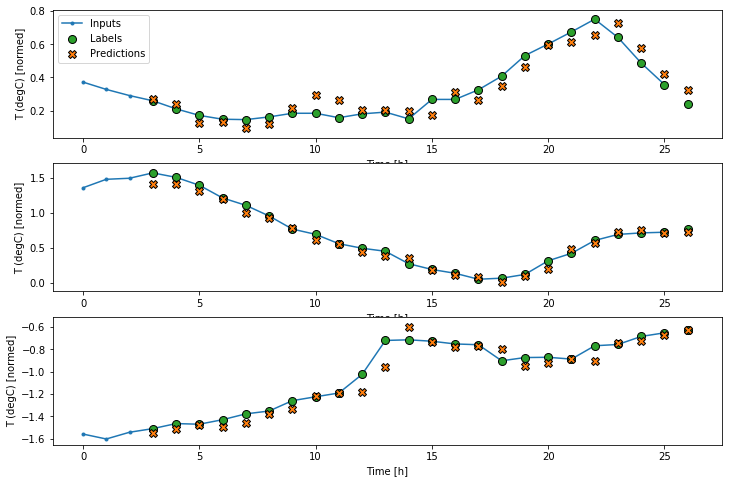

In [58]:
wide_conv_window.plot(conv_model)

#### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

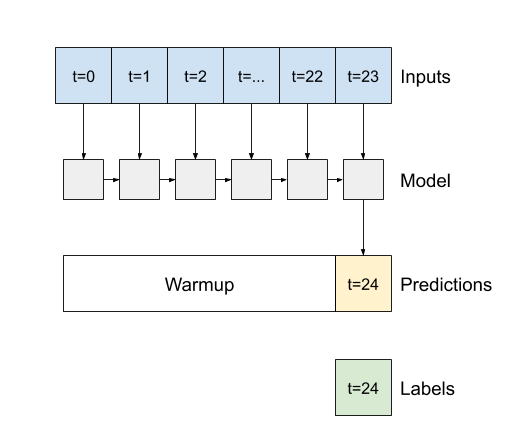

In [75]:
rnn_window = WindowGenerator(
    input_width=24,
    label_width=1,
    shift=1,
    label_columns=['T (degC)'])

rnn_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['T (degC)']

In [76]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [77]:
print('Input shape:', rnn_window.example[0].shape)
print('Output shape:', lstm_model(rnn_window.example[0]).shape)

<bound method WindowGenerator.split_window of Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['T (degC)']>
Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [74]:
lstm_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (32, 32)                  6656      
_________________________________________________________________
dense_13 (Dense)             (32, 1)                   33        
Total params: 6,689
Trainable params: 6,689
Non-trainable params: 0
_________________________________________________________________


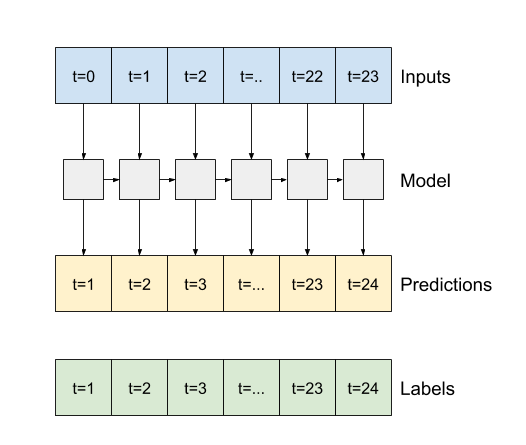

This can be implemented in 2 ways, either to use with return_sequences=True or add dense layer with output window shape. 

In [78]:
lstm_model_1 = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [79]:
print('Input shape:', rnn_window.example[0].shape)
print('Output shape:', lstm_model_1(rnn_window.example[0]).shape)

Input shape: (32, 24, 19)
Output shape: (32, 24, 1)


In [ ]:
history = compile_and_fit(lstm_model_1, rnn_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model_1.evaluate(rnn_window.val)
test_performance['LSTM'] = lstm_model_1.evaluate(rnn_window.test, verbose=0)

#### Multi-output models

The models so far all predicted a single output feature, T (degC), for a single time step.

All of these models can be converted to predict multiple features just by changing the number of units in the output layer and adjusting the training windows to include all features in the labels.

In [ ]:
# Examples:

dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])


**Autoregressive RNN Model**

The above models all predict the entire output sequence as a in a single step.

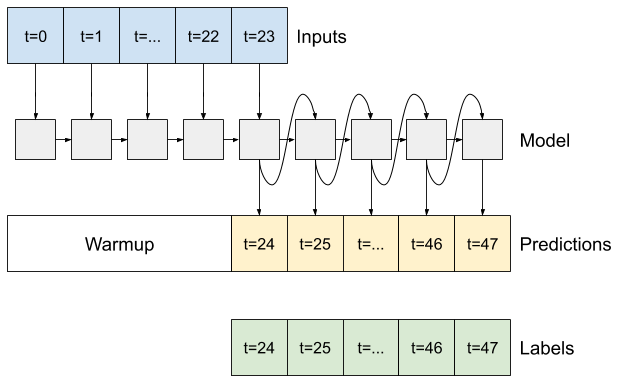


In some cases it may be helpful for the model to decompose this prediction into individual time steps. Then each model's output can be fed back into itself at each step and predictions can be made conditioned on the previous one.

One clear advantage to this style of model is that it can be set up to produce output with a varying length.



<bound method WindowGenerator.split_window of Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None>


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

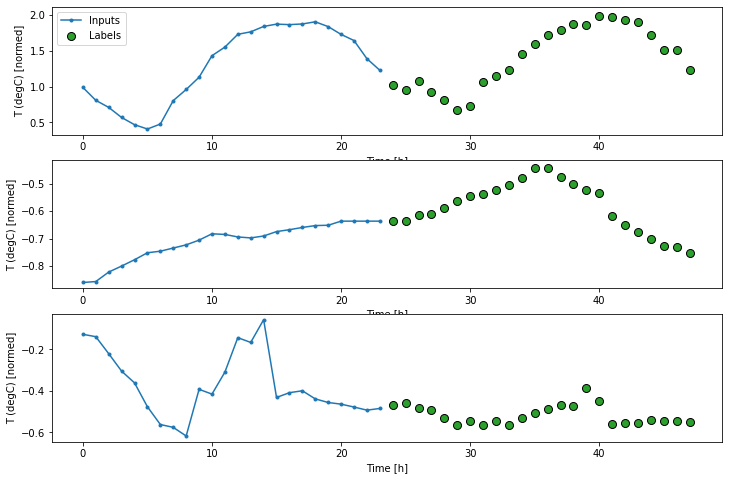

In [86]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

In [100]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
            
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the lstm state
        prediction, state = self.warmup(inputs)

        # Insert the first prediction
        predictions.append(prediction)

        # Run the rest of the prediction steps
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

In [101]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 19])

In [102]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 19)


In [104]:
history = compile_and_fit(feedback_model, multi_window)
IPython.display.clear_output()

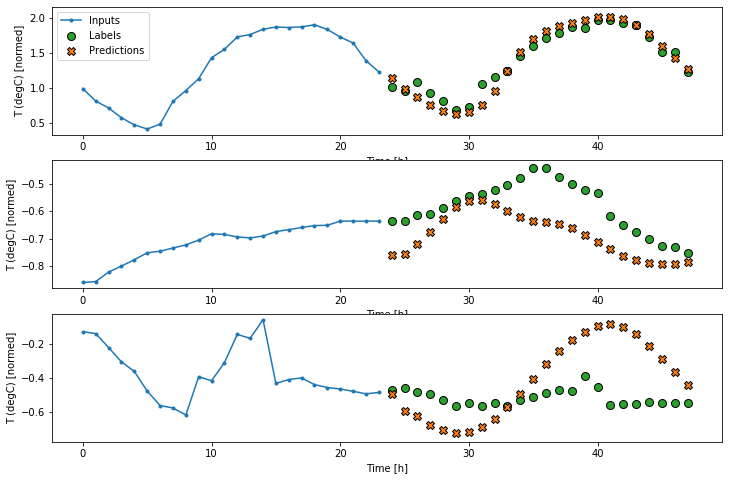

In [105]:
multi_window.plot(feedback_model)